In [ ]:
!pwd

/content


# Initialization Section

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import tensorflow as tf # tensorflow v2.11.0
import numpy as np
import pandas as pd
import os

import re
from sklearn.preprocessing import OneHotEncoder
from typing import NamedTuple
from tqdm.auto import tqdm
import pickle
# import mmap
import gc
tqdm.pandas()

In [3]:
class Report:
  preserved_names = ["REPORT", "SECTION"]

  def __init__(self, name):
    super().__setattr__("name", name)
    super().__setattr__("_Report__conclusion", f"REPORT: {name}\n{('-' * (8 + len(name)))}\n")

  def __setattr__(self, name, value):
    if name in Report.preserved_names:
      raise KeyError(f"preserved name, {name}")
    
    _name = name.replace("_", " ")
    if not hasattr(self, name):
      new_line = self.__conclusion + f"{_name}: {value}\n"
      super().__setattr__("_Report__conclusion", new_line)
    else:
      start_index = self.__conclusion.find(f"{_name}:")
      endln_index = self.__conclusion.find("\n", start_index)
      super().__setattr__("_Report__conclusion", 
                          self.__conclusion[:start_index] \
                          + f"{_name}: {value}" \
                          + self.__conclusion[endln_index:])

    super().__setattr__(name, value)

  def __str__(self):
    return self.__conclusion

  def __repr__(self):
    return str(self)

  def add_section(self, section_name):
    new_line = self.__conclusion +\
       f"\nSECTION: {section_name.upper()}\n{('-' * (9 + len(section_name)))}\n"
    super().__setattr__("_Report__conclusion", new_line)

  def save_report(self, path):
    with open(path, "w") as f:
      f.write(str(self))
      f.close()

In [4]:
test_set_prefixes = ["spiral.com", "onion.com", "insect.com", "cup.com"]

In [5]:
pkl_dir = "/content/drive/MyDrive/Colab Notebooks/preprocessed/AIT/"
dataset_prefix = "AIT."
prefix = "supervised." + "nolabeling."

ti = 3
test_prefix = test_set_prefixes[ti]

structured_train_pkl = pkl_dir+ dataset_prefix + prefix + test_prefix + "-as-testset." + "structured.trainset.pkl"
template_train_pkl = pkl_dir + dataset_prefix + prefix + test_prefix + "-as-testset." + "template.trainset.pkl"

structured_test_pkl = pkl_dir + dataset_prefix + prefix + test_prefix + "-as-testset." + "structured.testset.pkl"
template_test_pkl = pkl_dir + dataset_prefix + prefix + test_prefix + "-as-testset." + "template.testset.pkl"

model_name = "word2vec-google-news-300"
embedder_dir = "/content/drive/MyDrive/Colab Notebooks/word2Vec/"
fine_tune_files = embedder_dir + dataset_prefix + prefix + test_prefix + "-as-testset." + model_name + ".txt"

prep_path = f"{embedder_dir}{dataset_prefix}{prefix}{test_prefix}-as-testset.{model_name}.object.pkl"

batch_size = 32
min_length = 9

seq_lines_len = 5
seq_lines_step = 1

sample_ratio = 1
desample_quantile = 0.9

epochs = 5
exp_prefix = f"{seq_lines_len}_lines-downsampling-normal-{sample_ratio}-Q{int(desample_quantile*100):d}."
reporter = Report(name = f"{exp_prefix}{prefix}{test_prefix}-as-testset.report")

training_dir = "/content/drive/MyDrive/Colab Notebooks/training_model"
if not os.path.exists(training_dir): os.mkdir(training_dir)
checkpoint_path = training_dir + "/{prefix}cp-{epoch:04d}.ckpt"

In [ ]:
EmbeddingShape = NamedTuple("EmbeddingShape", [("vocab_size", int), ("embedding_size", int)])
'''(NamedTuple) class for embedding shape contain vocab_size and embedding_size'''

class LogPreprocessor(object):
    """LogPreprocessor
    class for preprocessing data before feed to model
    
    Args:
        record_unknow (bool): whether recording unknown word from preprocessing process or not. Defaults to False.
    """
    
    def __init__(self, record_unknow=False) -> None:
        if record_unknow: 
            self.unknow_words = dict()
            '''dictionary for counting ocurred unknow word from preprocessing process where keys is word and value is occuring number'''
    
    @staticmethod
    def text_cleansing(text):
        """(static method) text_cleansing.
        method for cleansing log text.
        
        Args:
            text (str): log text to cleansing special character.

        Returns:
            str: cleansed log text.
        """
        regex_except_token = r'\B(?!<\w+>\B)[^\w\s]'
        regex_expect_words = r'[^\w<>]+'
        output = re.sub(regex_except_token, '', text)
        output = re.sub(regex_expect_words, ' ', output)
        return output
    
    @classmethod
    def load_object(cls, path):
        with open(path, 'rb') as inp:
          obj = pickle.load(inp)
          inp.close()

        print(f"vocab size: {obj.embedding_shape.vocab_size}")
        print(f"embedding size: {obj.embedding_shape.embedding_size}")

        return obj

    def save_object(self, path):
        with open(path, 'wb') as outp:
            pickle.dump(self, outp, -1)

    def load_word2vec_format(self, 
                             file_path, 
                             unknow_token=None, 
                             unknow_repr=None,
                             chunk_size=0
                             ):
        """(instance method) load_word2vec_format
        loading word2vec format file to extract embeadding metrix

        Args:
            file_path (str): file's path to word2vec format file (.txt)
            unknow_token (str, optional): word for represent unknown word (e.g. '<OOV>'). 
            Defaults to None.
            unknow_repr (_ArrayLike, optional): word vector for represent unknown word. 
            if 'unknow_repr' is not set but 'unknow_token' is set 
            it will use zero vector as unknow represent vector. Defaults to None.
        """
        # CHUNK_SIZE = mmap.PAGESIZE * chunk_size

        with open(file_path, "r") as f:
            # vec = dict()
            first_line = f.readline().split()
            vocab_size = int(first_line[0])
            embedding_size = int(first_line[-1])
            print(f"vocab size: {vocab_size}")
            print(f"embedding size: {embedding_size}")
            vec = np.zeros(shape=(vocab_size, embedding_size), dtype="float32")
            words_indices = dict()
            # f.seek(0)
            print(f"reading file: {file_path}")
            for i, l in tqdm(
                enumerate(f.readlines()), 
                total=vocab_size,
                desc="build embedding matrix"
                ):
                data = list(filter(None, re.split(" +", l)))
                try:
                  vec[i] = np.array(data[1:], dtype=np.float32)
                  words_indices[data[0]] = i
                except ValueError as e:
                  print(f"ValueError: {data[0]}: {len(data[1:])}")
                  raise e
                # if len(vec[data[0]]) != embedding_size:
                #     print("got unexpected shape at {} ,{}".format(
                #         data[0], len(vec[data[0]]) )
                #     )
                #     print("at line: ", l)
            # if chunk_size == 0:
            #     for l in f.readlines():
            #         data = list(filter(None, re.split(" +", l)))
            #         vec[data[0]] = np.array(data[1:], dtype=np.float32)
            # else:
            #     TOTAL_SIZE = mmap.mmap(f.fileno(), 0, access=mmap.ACCESS_READ).size()
            #     last_line = ""
            #     for offset in range(0, TOTAL_SIZE, CHUNK_SIZE):
            #         READ_SIZE = CHUNK_SIZE if offset + CHUNK_SIZE <= TOTAL_SIZE else TOTAL_SIZE % CHUNK_SIZE
            #         mm = mmap.mmap(f.fileno(), 
            #                        length=READ_SIZE, 
            #                        access=mmap.ACCESS_READ, 
            #                        offset=offset # offset must be multiple of PAGESIZE
            #                        )
            #         text = last_line + mm.read().decode()
            #         lines = text.splitlines()
            #         last_line = "" if text.endswith('\n') else lines.pop()

            #         for l in lines:
            #             try:
            #               data = list(filter(None, re.split(" +", l)))
            #               vec[data[0]] = np.array(data[1:], dtype=np.float32)
            #               if len(vec[data[0]]) != embedding_size:
            #                   print("got unexpected shape at {} ,{}".format(
            #                       data[0], len(vec[data[0]]) )
            #                   )
            #             except:
            #               print("error data: {}" % data)
            #               print("line (len={}): {}".format(len(l), l))
            #     del text, lines, last_line
            #     mm.close()

            f.close()
                
        # embedding_size = int(vec.pop(list(vec.keys())[0])[0])
        if unknow_token is not None:
            try:
                unknow_idx = words_indices[unknow_token]
                unknow_vec = vec[unknow_idx]
                # unknow_vec = vec[unknow_token]
            except AttributeError:
                print(f"there's not '{unknow_token}' in dictionary.")
                if unknow_repr:
                    assert len(unknow_repr) == embedding_size, \
                        f"unknown represent vector must same shape with embedding size (expected {embedding_size}, got {len(unknow_repr)})"
                else:
                    unknow_repr = np.zeros(embedding_size, dtype="float32")
                # vec[unknow_token] = unknow_repr
                vec = np.append(vec, [unknow_repr], axis=0)
                words_indices[unknow_token] = vec.shape[0] - 1
            
            self.unknow_token = unknow_token
        else: 
            self.unknow_token = None
        
        vocab_size = vec.shape[0]
        self.word_vectors = vec
        self.words_indices = words_indices
        self.embedding_shape = EmbeddingShape(vocab_size, embedding_size)
        
        gc.collect()
    
    def indice_encode(self, line):
        """(instance method) indice_encode.
        encoding string words in log line to index number.

        Args:
            line (_ArrayLike[str]): array of tokenized string line.

        Returns:
            List[int]: list contains index number.
        """
        record_unknow = hasattr(self, "unknow_words")
        encoded = list()
        
        for word in line:
            try:
                i = self.words_indices[word]
            except KeyError:
                if record_unknow:
                    if word in self.unknow_words.keys(): self.unknow_words[word] += 1
                    else: self.unknow_words[word] = 0
                
                if self.unknow_token is None: continue
                else: i = self.words_indices[self.unknow_token]
            encoded.append(i)

        return np.array(encoded, dtype=np.uint32)
    
    def insert_new_word(self, word, vector, index=-1):
        """(instance method) insert_new_word
        insert a new word and vector to word dictionary at specified index
        
        Args:
            word (str): new word to insert
            vector (_ArrayLike[Float]): new vector to insert
            index (int, optional): insert at index if negative index will insert at (vocab_size + index + 1). Defaults to -1.
        """
        if index < 0: index = self.embedding_shape.vocab_size + index + 1
        assert word not in self.words_indices.keys(), \
            f"there is already exist input word in vocab at {self.words_indices[word]} index"
        assert np.ndim(vector) == 1, \
            f"expect 1 dim vector as a input but got {np.ndim(vector)}."
        assert len(vector) == self.embedding_shape.embedding_size, \
            f"insert vector's shape must match to embedding size. (got {np.shape(vector)})"
            
        new_word_vectors = np.insert(self.word_vectors, index, vector, axis=0)
        new_words_indices = { k: v if v < index else v + 1 for k, v in self.words_indices.items() }
        new_words_indices[word] = index
        new_embedding_shape = EmbeddingShape(self.embedding_shape.vocab_size + 1, self.embedding_shape.embedding_size)
        
        self.word_vectors = new_word_vectors
        self.words_indices = new_words_indices
        self.embedding_shape = new_embedding_shape
    
    def indice_padding(self, batch, padding_token, padding_size=0):
        """(instance method) indice_padding.
        padding tokenized array in batch by index number of padding_token.
        
        Args:
            batch (_ArrayLike[_ArrayLike[int]]): data batch of array of index number.
            padding_token (str): word for represent padding token (e.g. "<PADDING>") where padding token must in dictionary.
            padding_size (int, optional): size of output. if 'padding_size' is less than longest line in batch it will set to length of longest line is batch. Defaults to 0.

        Returns:
            NDArray[NDArray[int]]: array of padded batch data.
        """
        padding_idx = self.words_indices[padding_token]
        max_length = 0
        for inst in batch: 
            if len(inst) > max_length: max_length = len(inst)
        padding_size = max(padding_size, max_length)
        
        return np.array([ 
            np.pad(inst, (0, padding_size - len(inst)), constant_values=padding_idx) \
                for inst in tqdm(batch, desc="padding")
                ], dtype=np.float32)
    
    @staticmethod
    def build_label(y, classes=None):
        """(static method) build_label
        build labels array using one-hot encoding

        Args:
            y (_ArrayLike): input labels
            classes (_ArrayLike, optional): array contains all classes. if None, it will set to unique label of input. Defaults to None.

        Returns:
            _Array[_Array[int]]: array of one-hot label where shape is (input_size, num_classes)
        """
        if classes is None:
            classes = np.unique(y)
            
        encoder = OneHotEncoder(categories=[classes], dtype=np.int8)
        return encoder.fit_transform(y).toarray()

    @staticmethod
    def build_sequence(
              tokens, 
              labels, 
              sequence_length,
              step=1, 
              min_len = 9,
              labels_type="multi-label",
            ):
        assert sequence_length > 0, "sequence_length must be positive integer more."
        assert len(tokens) == len(labels), "len of tokens and labels not equal."
        sequence_length -= 1
        tokens_seq = list() if sequence_length >= 1 else tokens
        labels_seq = list()
        for i in tqdm(range(0, len(tokens) - sequence_length, step), desc="build {} lines sequence".format(sequence_length + 1)):
            if sequence_length >= 1:
                seq = np.concatenate(tokens[i:i + sequence_length]).astype("uint32")
                if len(seq) < min_len:
                  seq = np.pad(seq, (0, min_len - len(seq)), constant_values=0)
                tokens_seq.append(seq)
            
                if labels_type == "multi-label":
                    labels_seq.append(labels[i:i + sequence_length])
                elif labels_type == "binary":
                    labels_seq.append( 
                        np.array([0, 1], dtype="bool") \
                        if 1 in labels[i:i + sequence_length] else \
                          np.array([1, 0], dtype="bool")
                        )
                elif labels_type == "last":
                    labels_seq.append( 
                        np.array([0, 1], dtype="bool") \
                        if labels[i + sequence_length - 1] == 1 else \
                        np.array([1, 0], dtype="bool")
                    )
            else: labels_seq.append(
                np.array([0, 1], dtype="bool") \
                if labels[i] == 1 else np.array([1, 0], dtype="bool"))
        return tokens_seq, np.array(labels_seq, dtype=np.int8)


In [ ]:
if not os.path.exists(prep_path):
    prep = LogPreprocessor()
    # extract word2vec format file to embedding matrix and words indice
    # change this path for select another embedding method
    prep.load_word2vec_format(fine_tune_files)
    # insert "<PAD>" at first index of embedding matrix with zeros vector
    # if padding token is represented as zeros vector, unknown token must be represented
    # as non-zeros vector. (that mean if you set unknow_token for load_word2vec_format you
    # have to set unknow_repr too or using non-zero vector for represent padding token).
    prep.insert_new_word("<PAD>", np.zeros(prep.embedding_shape.embedding_size), index=0)
    prep.save_object(prep_path)
else: prep = LogPreprocessor.load_object(prep_path)

vocab size: 3000064
embedding size: 300
reading file: /content/drive/MyDrive/Colab Notebooks/word2Vec/AIT.supervised.nolabeling.cup.com-as-testset.word2vec-google-news-300.txt


build embedding matrix:   0%|          | 0/3000064 [00:00<?, ?it/s]

In [ ]:
# import time
# time.sleep(60)

# from google.colab import runtime
# runtime.unassign()

In [ ]:
class TextCNNConfig():
    """class for containing config of TextCNN model
    """
    
    def __init__(self,
                num_classes,
                vocab_size,
                embedding_size, 
                filter_sizes, 
                num_filters,
                sequence_length=None,
                dropout_rate=None,
                l2_reg_lambda=0.0,
                seed=42,
                pretrain_embedding_matrix=None
                ) -> None:
        self.num_classes = num_classes
        self.vocab_size = vocab_size
        self.embedding_size = embedding_size
        self.filter_sizes = filter_sizes
        self.num_filters = num_filters
        self.sequence_length = sequence_length
        self.dropout_rate = dropout_rate
        self.l2_reg_lambda = l2_reg_lambda
        self.seed = seed
        self.pretrain_embedding_matrix = pretrain_embedding_matrix
       
    def __repr__(self):
        return "TextCNNConfig:\n" +\
            f"num_classes:      {self.num_classes}\n" +\
            f"vocab_sizes:      {self.vocab_size}\n" +\
            f"embedding_size:   {self.embedding_size}\n" +\
            f"filter_sizes:     {self.filter_sizes}\n" +\
            f"num_filters:      {self.num_filters}\n" +\
            f"sequence_length:  {self.sequence_length}\n" +\
            f"dropout_rate:     {self.dropout_rate}\n" +\
            f"l2_reg_lambda:    {self.l2_reg_lambda}\n" +\
            f"seed:             {self.seed}\n" +\
            f"pretrain_embedding_matrix's shape: {np.shape(self.pretrain_embedding_matrix) if self.pretrain_embedding_matrix is not None else 'None'}"

class TextCNN(object):
    """CNN model for NLP task presented by Kim Y. in 2014 " Convolutional Neural Networks for Sentence Classification"

    Args:
        num_classes (int): number of classes for classification.
        vocab_size (int): number of known vocabularies. if pretrain_embedding_matrix is set, vocab_size must rely on pretrain_embedding_matrix' shape.
        embedding_size (int): length of embedding vector. if pretrain_embedding_matrix is set, embedding_size must rely on pretrain_embedding_matrix' shape.
        filter_sizes (_ArrayLike[int]): array contain convolution filter height.
        num_filters (int): number of each filter size.
        sequence_length (int, optional): length of input sequence. if None, input can be any length. Defualts is None.
        dropout_rate (float, optionanl): dropout rate for dropout layer. if None, model will not include dropout layer. Defualts is None.
        l2_reg_lambda (float, optional): L2 regularization factor for dense layer. Defaults is 0.0
        seed (int, optional): random seed. Defaults is 42.
        pretrain_embedding_matrix (_2DArray[float]): pretained embedding vectors. if None, embedding matrix will be initialized by random and it will be trained while trainning else it will be not trainable. Defaults is None
    """
    
    def __init__(self,
                num_classes,
                vocab_size,
                embedding_size, 
                filter_sizes, 
                num_filters,
                sequence_length=None,
                dropout_rate=None,
                l2_reg_lambda=0.0,
                seed=42,
                pretrain_embedding_matrix=None,
                output_activation="softmax"
        ) -> None:
        
        self.config = TextCNNConfig(
            num_classes,
            vocab_size,
            embedding_size, 
            filter_sizes, 
            num_filters,
            sequence_length,
            dropout_rate,
            l2_reg_lambda,
            seed,
            pretrain_embedding_matrix
        )
        
        # set global random seed
        if seed is not None: tf.random.set_seed(seed)
        # define input layer where input shape is (batch_size, sequence_length)
        # input data is 2d-array which each value is index of jth word's word vector 
        # in embedding metrix of ith line.
        input_word_idx = tf.keras.layers.Input(
            shape=(sequence_length,),
            dtype=tf.dtypes.int32,
            name="input-word-idx-layer"
        )
        
        # if pretrain_embedding_matrix is not defined, using random uniform for 
        # initailize embedding matrix
        embed_trainable = pretrain_embedding_matrix is None
        if pretrain_embedding_matrix is None:
            embed_initializers = tf.keras.initializers.RandomUniform(minval=-1, maxval=1)
        else:
            pretrain_embedding_matrix = np.array(pretrain_embedding_matrix)
            assert (vocab_size, embedding_size) == pretrain_embedding_matrix.shape, \
                f"shape of embedding_matrix must match to vocab_size and embedding_size (expect {(vocab_size, embedding_size)}, got {pretrain_embedding_matrix.shape})."
            embed_initializers = tf.keras.initializers.Constant(pretrain_embedding_matrix)
        # the embedding layer will defaultly use GPU memory
        # so to avoid error while trainning from optimizer which not support GPU
        # using tf.device("cpu:0") to place embedding matrix on CPU memory
        with tf.name_scope("embedding"), tf.device("cpu:0"):
            # define embedding layer where in put is array of index of word's vector in
            # embedding matrix. the output's shape is 
            # (batch_size, sequence_length, embedding_size)
            embed = tf.keras.layers.Embedding(
                input_dim=vocab_size,
                output_dim=embedding_size,
                embeddings_initializer=embed_initializers,
                input_length=sequence_length,
                trainable=embed_trainable,
                name="embedding-layer"
            )(input_word_idx)
            # define reshape layer for expand dimention of output from embedding layer to
            # (batch_size, sequence_length, embedding_size, 1) for suit to input of
            # 2d convolution layer which require input shape as 
            # (batch_size, weight, height, channel)
            expand_dim_embed = tf.keras.layers.Reshape(
                target_shape=(-1, embedding_size, 1),
                name="reshape-expand-dim-layer"
                )(embed)
        
        features = list() # list for contain output of each pooling layer
        with tf.name_scope("convolution"), tf.device("gpu:0"):
            # for loop to define each convolution layer of each size of the filter
            for size in filter_sizes:
                # define 2d convolution layer of n(num_filters) filters with kernel size
                # is (size, embedding_size) strides by (1, 1) and not use padding.
                # using ReLu as activation function also use bias. output's shape of this
                # layer is (batch_size, sequence_length - size + 1, 1, num_filters)
                conv = tf.keras.layers.Conv2D(
                    filters=num_filters,
                    kernel_size=(size, embedding_size),
                    strides=(1, 1),
                    padding="valid",
                    activation="relu",
                    use_bias=True,
                    kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.1),
                    bias_initializer=tf.keras.initializers.Constant(0.1),
                    name=f"conv-{size}_{embedding_size}-layer"
                )(expand_dim_embed)
                # define reshape layer for squeeze dimention of output from convolution layer 
                # to (batch_size, feature_map_height, num_filters)
                reshape = tf.keras.layers.Reshape(target_shape=(-1, num_filters), name=f"reshape-squeeze-{size}_{embedding_size}-layer")(conv)
                # define max-over-time pooling layer for extract max value from each 
                # feature map from convolution layers. where output is vector with 
                # shape of (batch_size, 1, num_filters)
                pooling = tf.keras.layers.GlobalMaxPool1D(name=f"global-max-pooling-{size}_{embedding_size}-layer")(reshape)
                # define flatten layer for shape output of pooling layer to 
                # (batch_size, num_filters)
                flatten_pooling = tf.keras.layers.Flatten(name=f"flatten-pooling-{size}_{embedding_size}-layer")(pooling)
                features.append(flatten_pooling)
        
        # define concatenate layer to concate all features for convolution & pooling 
        # process. where output shape is (batch_size, num_filters * len(filter_sizes))
        concat = tf.keras.layers.Concatenate(name="concatenate-layer")(features)
        
        # if dropout_rate is None, model will not include dropout layer
        if dropout_rate is not None:
            with tf.name_scope("dropout"):
                # define dropout layer with specified dropout_rate
                dropout = tf.keras.layers.Dropout(rate=dropout_rate)(concat)
                fc_input = dropout
        else: fc_input = concat
        
        with tf.name_scope("fully-connected"), tf.device("gpu:0"):
            # define output layer (fully connected layer) using Softmax as activation
            # and L2 as regularization method. where output is propability to be each 
            # class with output shape is (batch_size, num_classes).
            output = tf.keras.layers.Dense(
                units=num_classes,
                activation="softmax",
                use_bias=True,
                kernel_initializer=tf.keras.initializers.GlorotUniform(),
                bias_initializer=tf.keras.initializers.Constant(0.1),
                kernel_regularizer=tf.keras.regularizers.L2(l2=l2_reg_lambda),
                bias_regularizer=tf.keras.regularizers.L2(l2=l2_reg_lambda),
                name="output-layer"
                )(fc_input)
        
        # define model with all defined sequent layers
        self.model = tf.keras.Model(inputs=input_word_idx, outputs=output)
        

In [ ]:
def gen_series(X, y):
  assert len(X) == len(y), "length of X and y must equal."
  for i in range(len(X)):
    yield X[i], y[i]

def gen_predictor(X):
  for i in range(len(X)):
    yield X[i]

# Training Section

In [6]:
# load processed trainset of structured log and template log data
prep_train_struc_log = pd.read_pickle(structured_train_pkl)
prep_train_templ_log = pd.read_pickle(template_train_pkl)

In [7]:
K = ["access", "auth", "daemon", "mail", "user"]
for k in K:
  for w in prep_train_struc_log:
    data = prep_train_struc_log[w][k]
    print(f"{w}, {k}:")
    print(f"\t- total number {len(data): >10} ({len(data['EventTemplateIdent'].unique())})")
    print(f"\t- normal number {len(data.query('Label == 0')): >9} ({len(data.query('Label == 0')['EventTemplateIdent'].unique())})")
    print(f"\t- abnormal number {len(data.query('Label == 1')): >7} ({len(data.query('Label == 1')['EventTemplateIdent'].unique())})")

spiral.com, access:
	- total number     100445 (2895)
	- normal number     93075 (157)
	- abnormal number    7370 (2803)
onion.com, access:
	- total number      81963 (2810)
	- normal number     75534 (85)
	- abnormal number    6429 (2730)
insect.com, access:
	- total number     169340 (2896)
	- normal number    162367 (158)
	- abnormal number    6973 (2775)
spiral.com, auth:
	- total number       1202 (3)
	- normal number       929 (3)
	- abnormal number     273 (3)
onion.com, auth:
	- total number       1050 (3)
	- normal number       956 (3)
	- abnormal number      94 (1)
insect.com, auth:
	- total number       1134 (3)
	- normal number       954 (3)
	- abnormal number     180 (3)
spiral.com, daemon:
	- total number        905 (35)
	- normal number       901 (35)
	- abnormal number       4 (4)
onion.com, daemon:
	- total number       2133 (99)
	- normal number      2133 (99)
	- abnormal number       0 (0)
insect.com, daemon:
	- total number       2153 (101)
	- normal number      215

In [ ]:
total_len = 0
print("log data")
for w in prep_train_struc_log:
  for k in prep_train_struc_log[w]:
    total_len += len(prep_train_struc_log[w][k])
    print(f"{w}, {k}: {len(prep_train_struc_log[w][k])}")
print(f"total: {total_len}\n")

total_temp_len = 0
print("template data")
for w in prep_train_templ_log:
  for k in prep_train_templ_log[w]:
    total_temp_len += len(prep_train_templ_log[w][k])
    print(f"{w}, {k}: {len(prep_train_templ_log[w][k])}")
print(f"total: {total_temp_len}")

log data
spiral.com, auth: 1202
spiral.com, daemon: 905
spiral.com, user: 23270
spiral.com, mail: 59766
spiral.com, access: 100445
onion.com, daemon: 2133
onion.com, auth: 1050
onion.com, user: 16112
onion.com, access: 81963
onion.com, mail: 67873
insect.com, auth: 1134
insect.com, daemon: 2153
insect.com, mail: 110016
insect.com, access: 169340
insect.com, user: 37868
total: 675230

template data
spiral.com, auth: 3
spiral.com, daemon: 35
spiral.com, access: 2895
spiral.com, user: 26
spiral.com, mail: 6
onion.com, daemon: 99
onion.com, auth: 3
onion.com, access: 2810
onion.com, user: 25
onion.com, mail: 7
insect.com, auth: 3
insect.com, mail: 8
insect.com, daemon: 101
insect.com, user: 26
insect.com, access: 2896
total: 8943


In [ ]:
# encode token to index of embedding matrix
for w in prep_train_struc_log:
  for k in prep_train_struc_log[w]:
    prep_train_struc_log[w][k]["Token_Indice_encoded"] = \
        prep_train_struc_log[w][k]["Token"].progress_apply(prep.indice_encode)

  0%|          | 0/1202 [00:00<?, ?it/s]

  0%|          | 0/905 [00:00<?, ?it/s]

  0%|          | 0/23270 [00:00<?, ?it/s]

  0%|          | 0/59766 [00:00<?, ?it/s]

  0%|          | 0/100445 [00:00<?, ?it/s]

  0%|          | 0/2133 [00:00<?, ?it/s]

  0%|          | 0/1050 [00:00<?, ?it/s]

  0%|          | 0/16112 [00:00<?, ?it/s]

  0%|          | 0/81963 [00:00<?, ?it/s]

  0%|          | 0/67873 [00:00<?, ?it/s]

  0%|          | 0/1134 [00:00<?, ?it/s]

  0%|          | 0/2153 [00:00<?, ?it/s]

  0%|          | 0/110016 [00:00<?, ?it/s]

  0%|          | 0/169340 [00:00<?, ?it/s]

  0%|          | 0/37868 [00:00<?, ?it/s]

In [ ]:
# build label array to one hot format
# label = LogPreprocessor.build_label(prep_train_struc_log["Label"].to_numpy().reshape((-1, 1)), classes=[0, 1])
tokens = { w: dict() for w in prep_train_struc_log }
labels = { w: dict() for w in prep_train_struc_log }
# sequence mode
for w in prep_train_struc_log:
  for k in prep_train_struc_log[w]:
    tokens[w][k], labels[w][k] = LogPreprocessor.build_sequence(
        prep_train_struc_log[w][k]["Token_Indice_encoded"].values,
        prep_train_struc_log[w][k]["Label"].values,
        sequence_length = seq_lines_len, step = seq_lines_step,
        labels_type = "last",
        min_len = min_length,
        )

build 5 lines sequence:   0%|          | 0/1198 [00:00<?, ?it/s]

build 5 lines sequence:   0%|          | 0/901 [00:00<?, ?it/s]

build 5 lines sequence:   0%|          | 0/23266 [00:00<?, ?it/s]

build 5 lines sequence:   0%|          | 0/59762 [00:00<?, ?it/s]

build 5 lines sequence:   0%|          | 0/100441 [00:00<?, ?it/s]

build 5 lines sequence:   0%|          | 0/2129 [00:00<?, ?it/s]

build 5 lines sequence:   0%|          | 0/1046 [00:00<?, ?it/s]

build 5 lines sequence:   0%|          | 0/16108 [00:00<?, ?it/s]

build 5 lines sequence:   0%|          | 0/81959 [00:00<?, ?it/s]

build 5 lines sequence:   0%|          | 0/67869 [00:00<?, ?it/s]

build 5 lines sequence:   0%|          | 0/1130 [00:00<?, ?it/s]

build 5 lines sequence:   0%|          | 0/2149 [00:00<?, ?it/s]

build 5 lines sequence:   0%|          | 0/110012 [00:00<?, ?it/s]

build 5 lines sequence:   0%|          | 0/169336 [00:00<?, ?it/s]

build 5 lines sequence:   0%|          | 0/37864 [00:00<?, ?it/s]

In [ ]:
reporter.add_section("sequence log")
reporter.sequence_length = seq_lines_len
reporter.sequence_step = seq_lines_step

In [ ]:
train_input = { w: dict() for w in prep_train_struc_log }

for w in prep_train_struc_log:
  for k in prep_train_struc_log[w]:
    train_input[w][k] = pd.concat([
                    pd.DataFrame(labels[w][k], columns=["normal_label", "abnormal_label"]),
                    pd.DataFrame({"Tokens": tokens[w][k]}),
                  ], axis=1)
    
del tokens, labels

In [ ]:
import hashlib

def build_token_seqId(token_seq):
  token_seq = list(np.array(token_seq).astype(str))
  seq_str = "".join(token_seq).encode()
  return hashlib.md5(seq_str).hexdigest()

for w in prep_train_struc_log:
  for k in prep_train_struc_log[w]:
    train_input[w][k]["SeqId"] = train_input[w][k]["Tokens"].progress_apply(build_token_seqId)

  0%|          | 0/1198 [00:00<?, ?it/s]

  0%|          | 0/901 [00:00<?, ?it/s]

  0%|          | 0/23266 [00:00<?, ?it/s]

  0%|          | 0/59762 [00:00<?, ?it/s]

  0%|          | 0/100441 [00:00<?, ?it/s]

  0%|          | 0/2129 [00:00<?, ?it/s]

  0%|          | 0/1046 [00:00<?, ?it/s]

  0%|          | 0/16108 [00:00<?, ?it/s]

  0%|          | 0/81959 [00:00<?, ?it/s]

  0%|          | 0/67869 [00:00<?, ?it/s]

  0%|          | 0/1130 [00:00<?, ?it/s]

  0%|          | 0/2149 [00:00<?, ?it/s]

  0%|          | 0/110012 [00:00<?, ?it/s]

  0%|          | 0/169336 [00:00<?, ?it/s]

  0%|          | 0/37864 [00:00<?, ?it/s]

In [ ]:
reporter.add_section("training set")
reporter.training_num_lines = sum([ sum([len(data) for data in S.values()]) for S in prep_train_struc_log.values() ])
reporter.training_num_templates = sum([ sum([len(data) for data in S.values()]) for S in prep_train_templ_log.values() ])
reporter.training_size = sum([ sum([len(data) for data in S.values()]) for S in train_input.values() ])
reporter.training_num_patterns = sum([ sum([len(data["SeqId"].unique()) for data in S.values()]) for S in train_input.values() ])
reporter.training_abnormal = sum([ sum([ (data["abnormal_label"].sum()) for data in S.values()]) for S in train_input.values() ])
reporter.training_normal = reporter.training_size - reporter.training_abnormal

In [ ]:
del prep_train_struc_log, prep_train_templ_log
gc.collect()

146

In [ ]:
import random

def occurence_desampling(sr, sample_ratio, labels, desampling_class, threshold=0, random_state=0):
  assert sample_ratio > 0 and sample_ratio <= 1, "sample_ratio must in (0, 1]."
  assert not((desampling_class is None) ^ (labels is None)), \
    "both of desampling_class and labels must be None or not None."
  if labels is not None: 
    assert len(labels) == len(sr), \
    "length of data and labels must match."
  
  # value_counts = sr.value_counts()
  # desampled_indx = pd.Index([])
  # for i, row in tqdm(enumerate(sr.value_counts().items()), desc="desampling"):
  #   id, freq = row
  #   if labels[i] not in desampling_class: continue
  #   if freq <= threshold: continue
  #   n_sample = int(sample_ratio * freq)
  #   sample_idx = sr.where(sr == id)\
  #                   .dropna()\
  #                   .sample(n_sample, random_state=random_state)\
  #                   .index
  #   desampled_indx = desampled_indx.append(sample_idx)

  group = {id: [] for i, id in tqdm(
            enumerate(sr), total=len(sr), desc="1/4: initiate group") \
           if labels[i] in desampling_class }
  except_group = [ idx for i, idx in tqdm(
            enumerate(sr.index), total=len(sr), desc="2/4: except group") \
                  if labels[i] not in desampling_class ]
  for idx, id in tqdm(sr.items(), total=len(sr), desc="3/4: grouping sequence"):
    if id in group: group[id].append(idx)

  random.seed(random_state)
  desampled_indx = [
      i for v in tqdm(group.values(), desc="4/4: sampling")\
        for i in (v if len(v) <= threshold \
                  else random.sample(v, k=int(len(v) * sample_ratio)))
  ]
  sample_index = pd.Index(desampled_indx + except_group)

  return sample_index.sort_values()

In [ ]:
desample_th = { w: dict() for w in train_input }
desampled_indx = { w: dict() for w in train_input }
desample_train_input = { w: dict() for w in train_input }

for w in train_input:
  for k in train_input[w]:
    desample_th[w][k] = train_input[w][k]["SeqId"].value_counts().quantile(desample_quantile)
    desampled_indx[w][k] = occurence_desampling(train_input[w][k]["SeqId"],
                                          sample_ratio = sample_ratio,
                                          labels = train_input[w][k]["abnormal_label"],
                                          desampling_class=[0],
                                          threshold = desample_th[w][k],
                                          random_state = 42)
    
    desample_train_input[w][k] = train_input[w][k][
        train_input[w][k].index.isin(desampled_indx[w][k])
        ].reset_index(drop=True)

1/4: initiate group:   0%|          | 0/1198 [00:00<?, ?it/s]

2/4: except group:   0%|          | 0/1198 [00:00<?, ?it/s]

3/4: grouping sequence:   0%|          | 0/1198 [00:00<?, ?it/s]

4/4: sampling:   0%|          | 0/9 [00:00<?, ?it/s]

1/4: initiate group:   0%|          | 0/901 [00:00<?, ?it/s]

2/4: except group:   0%|          | 0/901 [00:00<?, ?it/s]

3/4: grouping sequence:   0%|          | 0/901 [00:00<?, ?it/s]

4/4: sampling:   0%|          | 0/93 [00:00<?, ?it/s]

1/4: initiate group:   0%|          | 0/23266 [00:00<?, ?it/s]

2/4: except group:   0%|          | 0/23266 [00:00<?, ?it/s]

3/4: grouping sequence:   0%|          | 0/23266 [00:00<?, ?it/s]

4/4: sampling:   0%|          | 0/259 [00:00<?, ?it/s]

1/4: initiate group:   0%|          | 0/59762 [00:00<?, ?it/s]

2/4: except group:   0%|          | 0/59762 [00:00<?, ?it/s]

3/4: grouping sequence:   0%|          | 0/59762 [00:00<?, ?it/s]

4/4: sampling:   0%|          | 0/66 [00:00<?, ?it/s]

1/4: initiate group:   0%|          | 0/100441 [00:00<?, ?it/s]

2/4: except group:   0%|          | 0/100441 [00:00<?, ?it/s]

3/4: grouping sequence:   0%|          | 0/100441 [00:00<?, ?it/s]

4/4: sampling:   0%|          | 0/89 [00:00<?, ?it/s]

1/4: initiate group:   0%|          | 0/2129 [00:00<?, ?it/s]

2/4: except group:   0%|          | 0/2129 [00:00<?, ?it/s]

3/4: grouping sequence:   0%|          | 0/2129 [00:00<?, ?it/s]

4/4: sampling:   0%|          | 0/327 [00:00<?, ?it/s]

1/4: initiate group:   0%|          | 0/1046 [00:00<?, ?it/s]

2/4: except group:   0%|          | 0/1046 [00:00<?, ?it/s]

3/4: grouping sequence:   0%|          | 0/1046 [00:00<?, ?it/s]

4/4: sampling:   0%|          | 0/15 [00:00<?, ?it/s]

1/4: initiate group:   0%|          | 0/16108 [00:00<?, ?it/s]

2/4: except group:   0%|          | 0/16108 [00:00<?, ?it/s]

3/4: grouping sequence:   0%|          | 0/16108 [00:00<?, ?it/s]

4/4: sampling:   0%|          | 0/748 [00:00<?, ?it/s]

1/4: initiate group:   0%|          | 0/81959 [00:00<?, ?it/s]

2/4: except group:   0%|          | 0/81959 [00:00<?, ?it/s]

3/4: grouping sequence:   0%|          | 0/81959 [00:00<?, ?it/s]

4/4: sampling:   0%|          | 0/28 [00:00<?, ?it/s]

1/4: initiate group:   0%|          | 0/67869 [00:00<?, ?it/s]

2/4: except group:   0%|          | 0/67869 [00:00<?, ?it/s]

3/4: grouping sequence:   0%|          | 0/67869 [00:00<?, ?it/s]

4/4: sampling:   0%|          | 0/97 [00:00<?, ?it/s]

1/4: initiate group:   0%|          | 0/1130 [00:00<?, ?it/s]

2/4: except group:   0%|          | 0/1130 [00:00<?, ?it/s]

3/4: grouping sequence:   0%|          | 0/1130 [00:00<?, ?it/s]

4/4: sampling:   0%|          | 0/16 [00:00<?, ?it/s]

1/4: initiate group:   0%|          | 0/2149 [00:00<?, ?it/s]

2/4: except group:   0%|          | 0/2149 [00:00<?, ?it/s]

3/4: grouping sequence:   0%|          | 0/2149 [00:00<?, ?it/s]

4/4: sampling:   0%|          | 0/345 [00:00<?, ?it/s]

1/4: initiate group:   0%|          | 0/110012 [00:00<?, ?it/s]

2/4: except group:   0%|          | 0/110012 [00:00<?, ?it/s]

3/4: grouping sequence:   0%|          | 0/110012 [00:00<?, ?it/s]

4/4: sampling:   0%|          | 0/72 [00:00<?, ?it/s]

1/4: initiate group:   0%|          | 0/169336 [00:00<?, ?it/s]

2/4: except group:   0%|          | 0/169336 [00:00<?, ?it/s]

3/4: grouping sequence:   0%|          | 0/169336 [00:00<?, ?it/s]

4/4: sampling:   0%|          | 0/100 [00:00<?, ?it/s]

1/4: initiate group:   0%|          | 0/37864 [00:00<?, ?it/s]

2/4: except group:   0%|          | 0/37864 [00:00<?, ?it/s]

3/4: grouping sequence:   0%|          | 0/37864 [00:00<?, ?it/s]

4/4: sampling:   0%|          | 0/280 [00:00<?, ?it/s]

In [ ]:
reporter.add_section("desampling")
reporter.desampling_condition = f"normal-occurence-gt-quantile-{desample_th}"
reporter.desampling_ratio = sample_ratio
reporter.desampled_size = sum([ sum([len(data) for data in S.values()]) for S in desample_train_input.values() ])
reporter.desampled_abnormal = sum([ sum([ data["abnormal_label"].sum() for data in S.values()]) for S in desample_train_input.values() ])
reporter.desampled_normal = reporter.desampled_size - reporter.desampled_abnormal

In [ ]:
reporter

REPORT: 5_lines-downsampling-normal-1-Q90.supervised.nolabeling.cup.com-as-testset.report
-----------------------------------------------------------------------------------------

SECTION: SEQUENCE LOG
---------------------
sequence length: 5
sequence step: 1

SECTION: TRAINING SET
---------------------
training num lines: 675230
training num templates: 8943
training size: 675170
training num patterns: 3108
training abnormal: 35793
training normal: 639377

SECTION: DESAMPLING
-------------------
desampling condition: normal-occurence-gt-quantile-{'spiral.com': {'auth': 434.0, 'daemon': 11.0, 'user': 66.0, 'mail': 810.3, 'access': 305.2000000000001}, 'onion.com': {'daemon': 23.0, 'auth': 290.5999999999999, 'user': 23.0, 'access': 1104.0, 'mail': 495.1}, 'insect.com': {'auth': 248.80000000000018, 'daemon': 23.0, 'mail': 1456.800000000004, 'access': 807.6000000000001, 'user': 128.60000000000002}}
desampling ratio: 1
desampled size: 675170
desampled abnormal: 35793
desampled normal: 63937

In [ ]:
# padding token with "<PAD>"
# padd_input = prep.indice_padding(prep_train_struc_log["Token_Indice_encoded"], "<PAD>")

# sequence mode
# padd_input = prep.indice_padding(desample_train_input["Tokens"], "<PAD>")
# labels = desample_train_input[["normal_label", "abnormal_label"]].to_numpy()

train_X = { w: dict() for w in desample_train_input }
train_batch = { w: dict() for w in desample_train_input }

for w in desample_train_input:
  for k in desample_train_input[w]:
    train_X[w][k] = tf.data.Dataset.from_generator(
        lambda: gen_series(
            desample_train_input[w][k]["Tokens"], 
            desample_train_input[w][k][["normal_label", "abnormal_label"]].to_numpy()
            ),
        output_signature=(
            tf.TensorSpec(
                shape=(None, ), 
                dtype="uint32",
                name="features"
                ),
            tf.TensorSpec(
                shape=(2, ), 
                dtype="uint8",
                name="labels"
                )
            )
    )

    train_X[w][k] = train_X[w][k].apply(tf.data.experimental.assert_cardinality(len(desample_train_input[w][k])))
    train_batch[w][k] = train_X[w][k].padded_batch(batch_size)

# you also can use this preprocessing pipeline for testset

In [ ]:
del desampled_indx, train_input
gc.collect()

61

In [ ]:
textcnn = TextCNN(
                num_classes=2,
                vocab_size=prep.embedding_shape.vocab_size,
                embedding_size=prep.embedding_shape.embedding_size,
                filter_sizes=[2, 3, 5, 7, 9],
                num_filters=3,
                sequence_length=None,
                dropout_rate=0.5,
                l2_reg_lambda=0.01,
                seed=42,
                pretrain_embedding_matrix=prep.word_vectors)

textcnn.config

TextCNNConfig:
num_classes:      2
vocab_sizes:      3000065
embedding_size:   300
filter_sizes:     [2, 3, 5, 7, 9]
num_filters:      3
sequence_length:  None
dropout_rate:     0.5
l2_reg_lambda:    0.01
seed:             42
pretrain_embedding_matrix's shape: (3000065, 300)

In [ ]:
# compile model using Adam optimizer with learning rate equal to 0.001
# categorical crossentropy as loss function
textcnn.model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[
        tf.keras.metrics.FalsePositives(),
        tf.keras.metrics.AUC()
    ]
)
textcnn.model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input-word-idx-layer (InputLay  [(None, None)]      0           []                               
 er)                                                                                              
                                                                                                  
 embedding-layer (Embedding)    (None, None, 300)    900019500   ['input-word-idx-layer[0][0]']   
                                                                                                  
 reshape-expand-dim-layer (Resh  (None, None, 300, 1  0          ['embedding-layer[0][0]']        
 ape)                           )                                                                 
                                                                                              

In [ ]:
reporter.add_section("model config")
reporter.num_classes = textcnn.config.num_classes
reporter.vocab_sizes = textcnn.config.vocab_size
reporter.embedding_size = textcnn.config.embedding_size
reporter.filter_sizes = textcnn.config.filter_sizes
reporter.num_filters = textcnn.config.num_filters
reporter.model_sequence_length = textcnn.config.sequence_length
reporter.dropout_rate = textcnn.config.dropout_rate
reporter.l2_reg_lambda = textcnn.config.l2_reg_lambda
reporter.optimizer = "adam"
reporter.loss = "categorical-crossentropy"
reporter.learning_rate = 1e-3

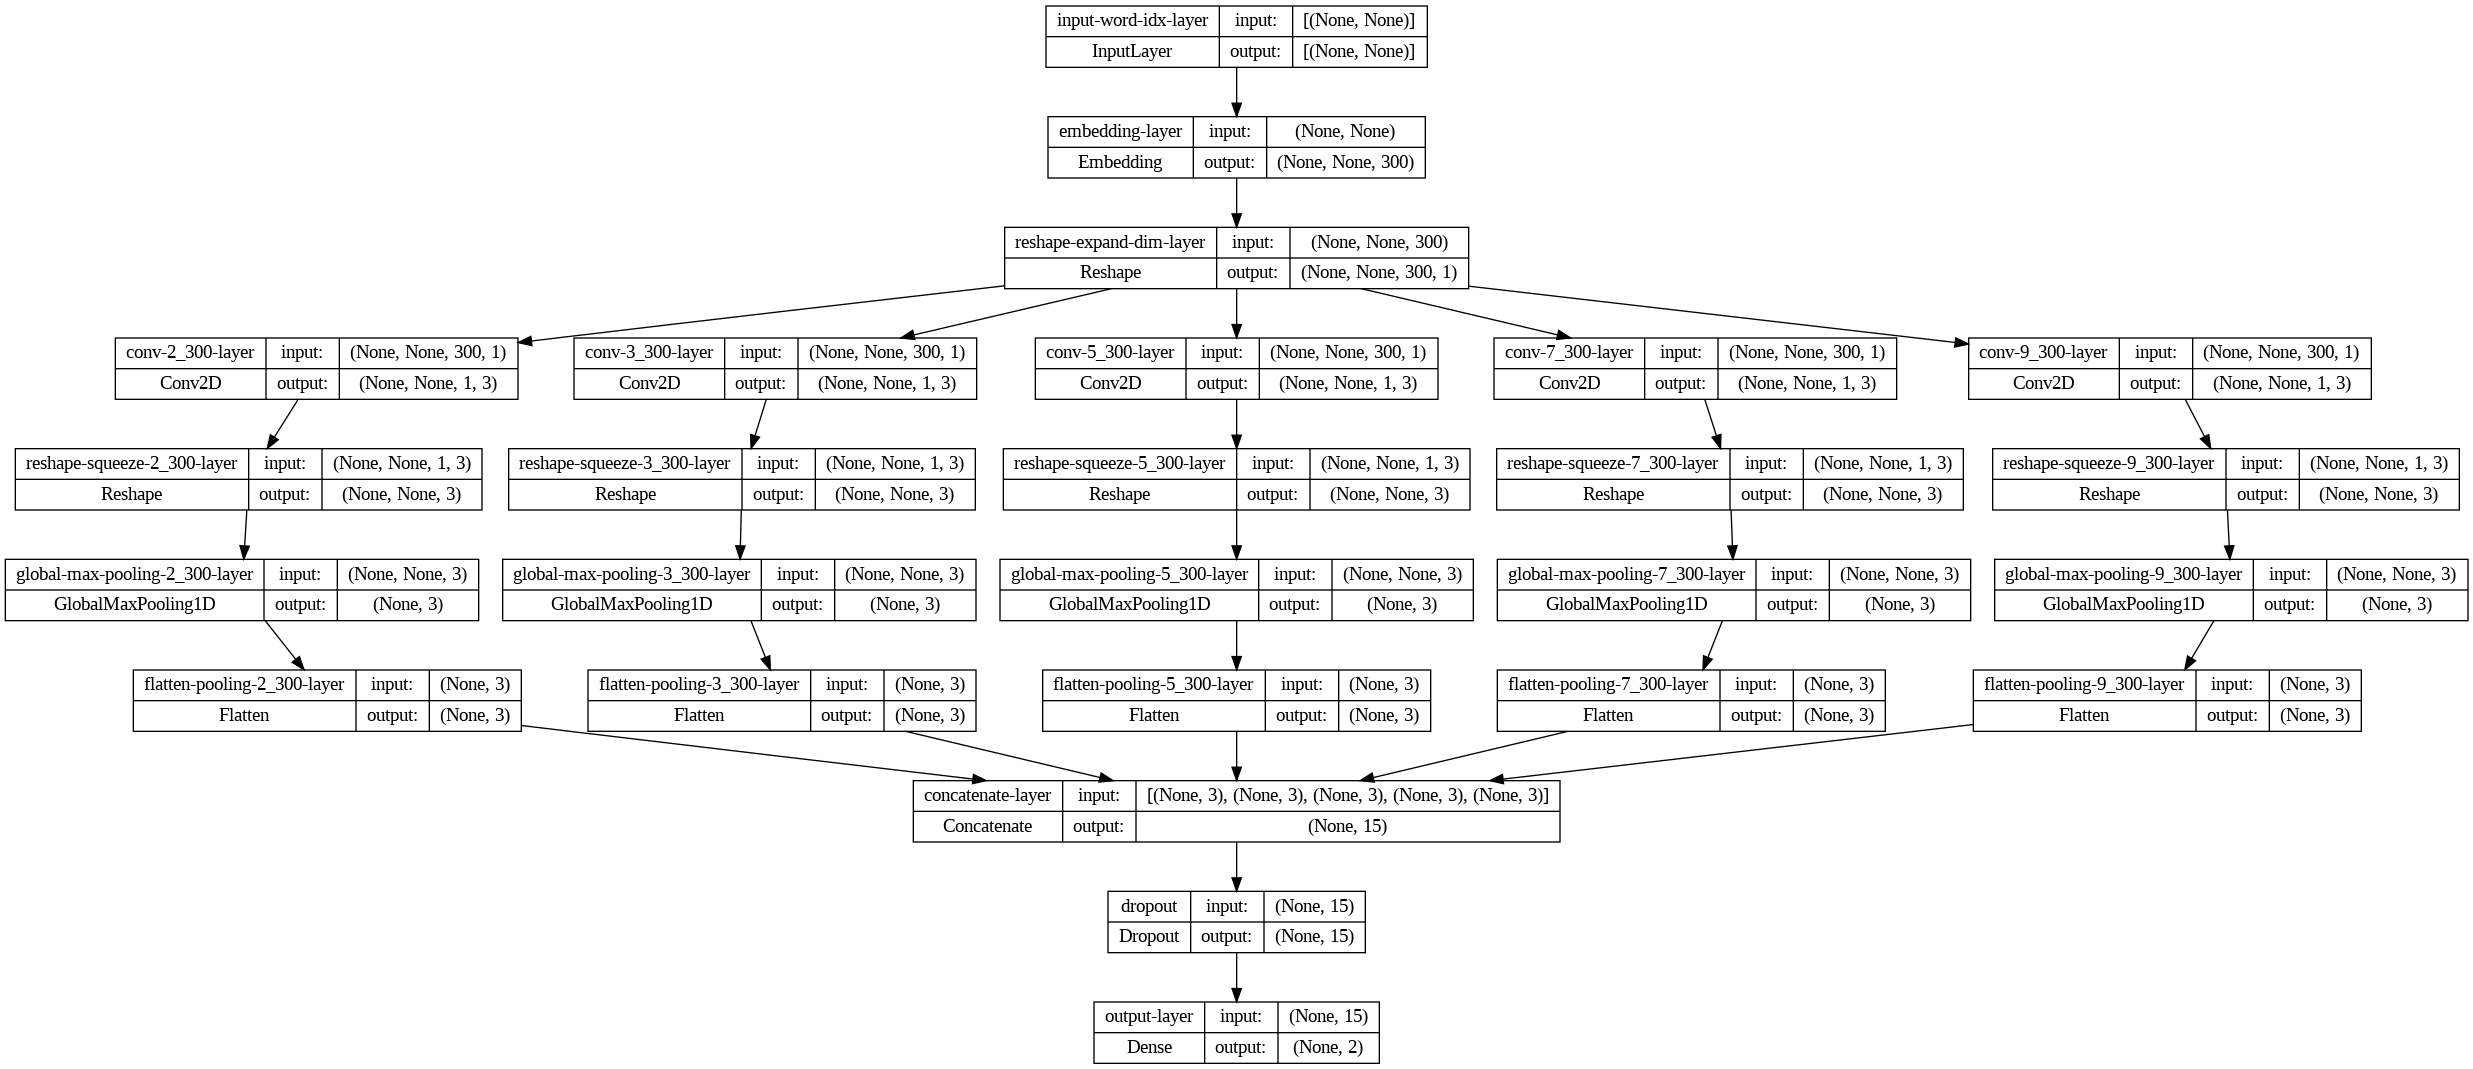

In [ ]:
# Note: If you don't want to visualize model achitecture 
# ***** you don't need to run this cell just skip it.
# You must install pydot (`pip install pydot`) and install graphviz 
# (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
# (e.g. for mac) $ brew install graphviz
# (e.g. for win) $ winget install graphviz
tf.keras.utils.plot_model(textcnn.model, "textcnn_model.png", show_shapes=True)

In [ ]:
from IPython.display import clear_output

weights = {0:0.01, 1:0.99}

hist = { w: dict() for w in train_batch }

i = 0
for w in train_batch:
  for k in train_batch[w]:
    clear_output(wait=True)
    print(f"({w}, {k}) {i}/15 [{'=' * i}{'.' * (15 - i)}]")
    hist[w][k] = textcnn.model.fit(
        train_batch[w][k],
        batch_size=None,
        epochs=epochs,
        shuffle=True,
        class_weight=weights
    )
    i += 1

(spiral.com, auth) 0/15 [...............]
Epoch 1/5
38/38 [==============================] - 3s 9ms/step - loss: 18.0975 - false_positives: 431.0000 - auc: 0.6473
Epoch 2/5
38/38 [==============================] - 0s 11ms/step - loss: 0.7483 - false_positives: 818.0000 - auc: 0.2955
Epoch 3/5
38/38 [==============================] - 0s 11ms/step - loss: 0.4183 - false_positives: 837.0000 - auc: 0.2547
Epoch 4/5
38/38 [==============================] - 0s 12ms/step - loss: 0.3311 - false_positives: 753.0000 - auc: 0.3017
Epoch 5/5
38/38 [==============================] - 0s 11ms/step - loss: 0.2799 - false_positives: 722.0000 - auc: 0.3254
(spiral.com, daemon) 1/15 [=..............]
Epoch 1/5
29/29 [==============================] - 0s 11ms/step - loss: 0.5628 - false_positives: 491.0000 - auc: 0.4298
Epoch 2/5
29/29 [==============================] - 0s 11ms/step - loss: 0.1999 - false_positives: 462.0000 - auc: 0.4823
Epoch 3/5
29/29 [==============================] - 0s 11ms/step - l

In [ ]:
del desample_train_input

In [ ]:
reporter.add_section("training config")
reporter.batch_size = None
reporter.epochs = epochs
reporter.class_weight = weights

In [ ]:
del train_batch
gc.collect()

3545

In [ ]:
textcnn.model.save_weights(checkpoint_path.format(prefix=f"{exp_prefix}{prefix}{test_prefix}", epoch=epochs))

In [ ]:
reporter

REPORT: 5_lines-downsampling-normal-1-Q90.supervised.nolabeling.cup.com-as-testset.report
-----------------------------------------------------------------------------------------

SECTION: SEQUENCE LOG
---------------------
sequence length: 5
sequence step: 1

SECTION: TRAINING SET
---------------------
training num lines: 675230
training num templates: 8943
training size: 675170
training num patterns: 3108
training abnormal: 35793
training normal: 639377

SECTION: DESAMPLING
-------------------
desampling condition: normal-occurence-gt-quantile-{'spiral.com': {'auth': 434.0, 'daemon': 11.0, 'user': 66.0, 'mail': 810.3, 'access': 305.2000000000001}, 'onion.com': {'daemon': 23.0, 'auth': 290.5999999999999, 'user': 23.0, 'access': 1104.0, 'mail': 495.1}, 'insect.com': {'auth': 248.80000000000018, 'daemon': 23.0, 'mail': 1456.800000000004, 'access': 807.6000000000001, 'user': 128.60000000000002}}
desampling ratio: 1
desampled size: 675170
desampled abnormal: 35793
desampled normal: 63937

In [ ]:
import time
time.sleep(60)

from google.colab import runtime
runtime.unassign()

# Training Evaluation Section

In [ ]:
prep_train_struc_log = pd.read_pickle(structured_train_pkl)

prep_train_struc_log["Token_Indice_encoded"] =\
    prep_train_struc_log.Token.progress_apply(
        prep.indice_encode
        )

train_tokens, train_labels = LogPreprocessor.build_sequence(
    prep_train_struc_log["Token_Indice_encoded"].values,
    prep_train_struc_log["Label"].values,
    sequence_length = seq_lines_len, step= seq_lines_step,
    labels_type = "last",
    min_len = min_length,
    )

del prep_train_struc_log
gc.collect()

train_X = tf.data.Dataset.from_generator(
    lambda: gen_predictor(train_tokens),
    output_signature=tf.TensorSpec(
                      shape=(None, ), 
                      dtype="uint32",
                      name="features"
                      )
    )

train_X = train_X.apply(
    tf.data.experimental.assert_cardinality(len(train_tokens))
    )

  0%|          | 0/6650088 [00:00<?, ?it/s]

build 5 lines sequence:   0%|          | 0/6650084 [00:00<?, ?it/s]

In [ ]:
train_batch = train_X.padded_batch(batch_size)

In [ ]:
textcnn = TextCNN(
                num_classes=2,
                vocab_size=prep.embedding_shape.vocab_size,
                embedding_size=prep.embedding_shape.embedding_size,
                filter_sizes=[2, 3, 5, 7, 9],
                num_filters=3,
                sequence_length=None,
                dropout_rate=0.5,
                l2_reg_lambda=0.01,
                seed=42,
                pretrain_embedding_matrix=prep.word_vectors)

In [ ]:
textcnn.model.load_weights(checkpoint_path.format(prefix=f"{exp_prefix}{prefix}{cv_prefix}", epoch=epochs))

In [ ]:
eval_pred = textcnn.model.predict(x=train_batch)

207816/207816 [==============================] - 1255s 6ms/step


In [ ]:
del train_tokens, textcnn
gc.collect()

108

In [ ]:
eval_pred_df = pd.DataFrame({
    "label": train_labels.argmax(axis=1),
    "normal_prob": eval_pred.T[0],
    "abnormal_prob": eval_pred.T[1]
    })

In [ ]:
confusion_matrix = tf.math.confusion_matrix(
    train_labels.argmax(axis=1), 
    eval_pred.argmax(axis=1)).numpy()
confusion_matrix

array([[6313763,       0],
       [ 336321,       0]], dtype=int32)

In [ ]:
positive, negative = 0, 1
tp = confusion_matrix[positive][positive]
fp = confusion_matrix[negative][positive]
tn = confusion_matrix[negative][negative]
fn = confusion_matrix[positive][negative]

pre = tp / (tp + fp) 
rec = tp / (tp + fn)
print(f"PRE: {pre}, REC {rec}")

acc = (tp + tn) / confusion_matrix.sum()
print(f"ACC: {acc}")

PRE: 0.9494260523626469, REC 1.0
ACC: 0.9494260523626469


In [ ]:
reporter.add_section(f"training result")
reporter.positive = positive
reporter.negative = negative
reporter.TP = tp
reporter.FP = fp
reporter.TN = tn
reporter.FN = fn
reporter.precision_0 = pre
reporter.recall_0 = rec
reporter.accuracy_0 = acc

In [ ]:
positive, negative = 1, 0
tp = confusion_matrix[positive][positive]
fp = confusion_matrix[negative][positive]
tn = confusion_matrix[negative][negative]
fn = confusion_matrix[positive][negative]

pre = tp / (tp + fp) 
rec = tp / (tp + fn)
print(f"PRE: {pre}, REC {rec}")

acc = (tp + tn) / confusion_matrix.sum()
print(f"ACC: {acc}")

PRE: nan, REC 0.0
ACC: 0.9494260523626469


<ipython-input-20-a352cc1ea504>:7: RuntimeWarning: invalid value encountered in scalar divide
  pre = tp / (tp + fp)


In [ ]:
reporter.add_section(f"training result (reverse)")
reporter.precision_1 = pre
reporter.recall_1 = rec
reporter.accuracy_1 = acc

In [ ]:
reporter

REPORT: 5_lines-downsampling-normal-1-Q90.withlinetoken.supervised.40-60.nolabeling.cv2_report
----------------------------------------------------------------------------------------------

SECTION: TRAINING RESULT
------------------------
positive: 0
negative: 1
TP: 6313763
FP: 336321
TN: 0
FN: 0
precision 0: 0.9494260523626469
recall 0: 1.0
accuracy 0: 0.9494260523626469

SECTION: TRAINING RESULT (REVERSE)
----------------------------------
precision 1: nan
recall 1: 0.0
accuracy 1: 0.9494260523626469

# Testing section

In [ ]:
prep_test_struc_log = pd.read_pickle(structured_test_pkl)[["Token", "Label"]]
# prep_test_templ_log = pd.read_pickle(template_test_pkl)
# prep_test_struc_log = define_dtype(prep_test_struc_log, dtype_struc_log_map)
# prep_test_templ_log = define_dtype(prep_test_templ_log, dtype_templ_log_map)

# print("load testset: strunctured, template = ({}, {})"
#           .format( len(prep_test_struc_log), len(prep_test_templ_log) )
#     )

token_indice_encoded = prep_test_struc_log.Token.progress_apply(
    prep.indice_encode
    )

  0%|          | 0/3325044 [00:00<?, ?it/s]

In [ ]:
prep_test_struc_log

,Token,Label
0,"[<startline>, BIOS, e<, reserved, <endline>]",0
1,"[<startline>, BIOS, e<, reserved, <endline>]",0
2,"[<startline>, BIOS, e<, reserved, <endline>]",0
3,"[<startline>, BIOS, e<, usable, <endline>]",0
4,"[<startline>, RHH, kernel, module, initialized...",0
...,...,...
3325039,"[<startline>, Got, trap, from, peer, on, fd, <...",0
3325040,"[<startline>, Instrumentation, Service, Event,...",0
3325041,"[<startline>, Got, trap, from, peer, on, fd, <...",0
3325042,"[<startline>, synchronized, to, stratum, <endl...",0


In [ ]:
test_tokens, test_labels = LogPreprocessor.build_sequence(
    token_indice_encoded.values,
    prep_test_struc_log["Label"].values,
    sequence_length = seq_lines_len, step= seq_lines_step,
    labels_type = "last",
    min_len = min_length,
    )
# test_label = LogPreprocessor.build_label(prep_test_struc_log["Label"].to_numpy().reshape((-1, 1)), classes=[0, 1]) 
# padd_test_input = prep.indice_padding(test_tokens, "<PAD>")

build 5 lines sequence:   0%|          | 0/3325040 [00:00<?, ?it/s]

In [ ]:
reporter.add_section("testing set")
reporter.testing_num_lines = len(prep_test_struc_log)
# reporter.testing_num_templates = len(prep_test_templ_log)
reporter.testing_size = len(test_tokens)
reporter.testing_abnormal = test_labels.argmax(axis=1).sum()
reporter.testing_normal = reporter.testing_size - reporter.testing_abnormal

In [ ]:
del prep_test_struc_log, token_indice_encoded #, prep_test_templ_log
gc.collect()

19

In [ ]:
test_X = tf.data.Dataset.from_generator(
    lambda: gen_predictor(test_tokens),
    output_signature=tf.TensorSpec(
                      shape=(None, ), 
                      dtype="uint32",
                      name="features"
                      )
    )

test_X = test_X.apply(
    tf.data.experimental.assert_cardinality(len(test_tokens))
    )
test_batch = test_X.padded_batch(batch_size)

In [ ]:
textcnn = TextCNN(
                num_classes=2,
                vocab_size=prep.embedding_shape.vocab_size,
                embedding_size=prep.embedding_shape.embedding_size,
                filter_sizes=[2, 3, 5, 7, 9],
                num_filters=3,
                sequence_length=None,
                dropout_rate=0.5,
                l2_reg_lambda=0.01,
                seed=42,
                pretrain_embedding_matrix=prep.word_vectors)

In [ ]:
textcnn.model.load_weights(checkpoint_path.format(prefix=f"{exp_prefix}{prefix}{cv_prefix}", epoch=epochs))

In [ ]:
pred = textcnn.model.predict(x=test_batch)

103908/103908 [==============================] - 604s 6ms/step


In [ ]:
del test_tokens, textcnn
gc.collect()

83

In [ ]:
pred_df = pd.DataFrame({
    "label": test_labels.argmax(axis=1),
    "normal_prob": pred.T[0],
    "abnormal_prob": pred.T[1]
    })
# prep_test_struc_log["Predict"] = pred.argmax(axis=1)

In [ ]:
pred_df

,label,normal_prob,abnormal_prob
0,0,NaN,NaN
1,0,NaN,NaN
2,0,NaN,NaN
3,0,NaN,NaN
4,0,NaN,NaN
...,...,...,...
3325035,0,NaN,NaN
3325036,0,NaN,NaN
3325037,0,NaN,NaN
3325038,0,NaN,NaN


In [ ]:
pred_df[pred_df.label == 1][["normal_prob", "abnormal_prob"]].to_numpy()

array([[nan, nan],
       [nan, nan],
       [nan, nan],
       ...,
       [nan, nan],
       [nan, nan],
       [nan, nan]], dtype=float32)

In [ ]:
confusion_matrix = tf.math.confusion_matrix(test_labels.argmax(axis=1), pred.argmax(axis=1)).numpy()
confusion_matrix

array([[3307567,       0],
       [  17473,       0]], dtype=int32)

In [ ]:
positive, negative = 0, 1
tp = confusion_matrix[positive][positive]
fp = confusion_matrix[negative][positive]
tn = confusion_matrix[negative][negative]
fn = confusion_matrix[positive][negative]

pre = tp / (tp + fp) 
rec = tp / (tp + fn)
print(f"PRE: {pre}, REC {rec}")

acc = (tp + tn) / confusion_matrix.sum()
print(f"ACC: {acc}")

PRE: 0.9947450256237519, REC 1.0
ACC: 0.9947450256237519


In [ ]:
reporter.add_section(f"testing result")
reporter.positive = positive
reporter.negative = negative
reporter.TP = tp
reporter.FP = fp
reporter.TN = tn
reporter.FN = fn
reporter.precision_0 = pre
reporter.recall_0 = rec
reporter.accuracy_0 = acc

In [ ]:
positive, negative = 1, 0
tp = confusion_matrix[positive][positive]
fp = confusion_matrix[negative][positive]
tn = confusion_matrix[negative][negative]
fn = confusion_matrix[positive][negative]

pre = tp / (tp + fp) 
rec = tp / (tp + fn)
print(f"PRE: {pre}, REC {rec}")

acc = (tp + tn) / confusion_matrix.sum()
print(f"ACC: {acc}")

PRE: nan, REC 0.0
ACC: 0.9947450256237519


<ipython-input-24-a352cc1ea504>:7: RuntimeWarning: invalid value encountered in scalar divide
  pre = tp / (tp + fp)


In [ ]:
reporter.add_section(f"testing result (reverse)")
reporter.precision_1 = pre
reporter.recall_1 = rec
reporter.accuracy_1 = acc

In [ ]:
reporter

REPORT: 5_lines-downsampling-normal-1-Q90.withlinetoken.supervised.40-60.nolabeling.cv2_report
----------------------------------------------------------------------------------------------

SECTION: TESTING SET
--------------------
testing num lines: 3325044
testing size: 3325040
testing abnormal: 17473
testing normal: 3307567

SECTION: TESTING RESULT
-----------------------
positive: 0
negative: 1
TP: 3307567
FP: 17473
TN: 0
FN: 0
precision 0: 0.9947450256237519
recall 0: 1.0
accuracy 0: 0.9947450256237519

SECTION: TESTING RESULT (REVERSE)
---------------------------------
precision 1: nan
recall 1: 0.0
accuracy 1: 0.9947450256237519

# Saving Result Section

In [ ]:
prep_test_struc_log = pd.read_pickle(structured_test_pkl)
prep_test_templ_log = pd.read_pickle(template_test_pkl)

In [ ]:
# prediction = pd.concat([
#     prep_test_struc_log.reset_index()[["Label", "EventId", "EventTemplateIdent", "Predict"]],
#     pred_df[["normal_prob", "abnormal_prob"]]
#     ], axis=1)

pred_df["Label"] = test_labels.argmax(axis=1)
for i in range(seq_lines_len):
  stop = len(prep_test_struc_log) - (seq_lines_len - i) + 1
  pred_df[f"EventId-{i + 1}"] = prep_test_struc_log["EventId"][i:stop].values

In [ ]:
from datetime import datetime

time_prefix = datetime.today().strftime("%d-%m-%y_%H-%M.")

report_dir = "/content/drive/MyDrive/Colab Notebooks/report/"
if not os.path.exists(report_dir):
  os.mkdir(report_dir)

reporter.save_report(report_dir + time_prefix + reporter.name)

test_prediction_result_dir = "/content/drive/MyDrive/Colab Notebooks/test_prediction/"
pred_df.to_parquet(test_prediction_result_dir + time_prefix + f"{exp_prefix}{prefix}-{epochs}.parquet")

In [ ]:
f = open(
    "/content/drive/MyDrive/Colab Notebooks/report/" +\
     "06-03-23_18-56.5_lines-downsampling-normal-0.3-Q90.withlinetoken.supervised.40-60.nolabeling.-report")